# RSDC
Structure:
1. Simulate data
2. Original Estimation Functions
3. Expectation Functions
4. Uniting functions



In [2]:
import numpy as np
import time
from scipy.stats import t, norm
import pandas as pd
from arch import arch_model
from tqdm import tqdm
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import skew, kurtosis
from scipy.stats.mstats import gmean


## Simulation
***


In [66]:
def simulate_data(K,T, parameters, transition_matrix, cholesky):
    # Initialize arrays to store the processes and variances
    processes = np.zeros((K, T))
    variances = np.zeros((K, T))
    states = np.zeros((T))
    innovations = np.zeros((K, T))
    
    # Initial variance (can be set equal to the long-term variance)
    variances[:, 0] = parameters[:, 0] / (1 - parameters[:, 1] - parameters[:, 2])
    states[0] = 0
    # Simulate the GARCH processes
    for t in range(1, T):
        state = int(states[t-1])
        current_state = np.random.choice(a=[0,1], p=transition_matrix[state])
        states[t] = current_state
        
        # Simulate standard normal innovations
        z = np.random.normal(0, 1, K)
        # Apply the Cholesky decomposition to introduce correlation
        correlated_z = cholesky[current_state,:,:] @ z
        # Update the variance
        variances[:, t] = parameters[:, 0] + parameters[:, 1] * (processes[:, t-1]**2) + parameters[:, 2] * variances[:, t-1]
        # Calculate the process values
        processes[:, t] = np.sqrt(variances[:, t]) * correlated_z[:]
    return processes, states, variances, innovations

def cholesky_form(matrix, N, K):
    cholesky = np.zeros((N, K, K))
    for n in range(N):
        cholesky[n,:,:] = np.linalg.cholesky(true_correlation_matrix[n,:,:])

    return cholesky
import numpy as np
def vectorized_simulate_data(K, T, parameters, transition_matrix, cholesky):
    # Pre-allocate arrays
    processes = np.zeros((K, T))
    variances = np.zeros((K, T))
    states = np.zeros(T, dtype=int)
    innovations = np.random.normal(0, 1, (K, T))  # Pre-generate all innovations
    
    # Initial variance
    variances[:, 0] = parameters[:, 0] / (1 - parameters[:, 1] - parameters[:, 2])
    
    # Simulate states with a Markov chain
    # This part is inherently sequential but let's try to minimize the loop's impact.
    for t in range(1, T):
        states[t] = np.random.choice([0, 1], p=transition_matrix[states[t-1]])
    
    # Vectorize the correlation application using pre-simulated innovations
    # Note: This approach changes the structure slightly, as we need to correlate all innovations first and then select based on state
    correlated_innovations = np.zeros((K, T))
    for state in range(transition_matrix.shape[0]):
        # Find indices where this state occurs
        state_indices = np.where(states == state)[0]
        if len(state_indices) > 0:
            for i in state_indices:
                correlated_innovations[:, i] = cholesky[state] @ innovations[:, i]
    
    # Update variances and processes in a vectorized way
    for t in range(1, T):
        variances[:, t] = parameters[:, 0] + parameters[:, 1] * (processes[:, t-1]**2) + parameters[:, 2] * variances[:, t-1]
        processes[:, t] = np.sqrt(variances[:, t]) * correlated_innovations[:, t]
    
    return processes, states, variances, innovations

def optimized_simulate_data(K, T, parameters, transition_matrix, cholesky):
    # Pre-allocate arrays
    processes = np.zeros((K, T))
    states = np.zeros(T, dtype=int)
    variances = np.zeros((K, T))
    
    # Pre-generate all innovations now assuming independence, correlate them later in loop
    innovations = np.random.normal(0, 1, (K, T))  
    
    # Initial variance
    variances[:, 0] = parameters[:, 0] / (1 - parameters[:, 1] - parameters[:, 2])
    
    # Simulate states with a Markov chain
    for t in range(1, T):
        states[t] = np.random.choice([0, 1], p=transition_matrix[states[t-1]])
    
    # Update variances and processes, applying Cholesky based on state
    for t in range(1, T):
        # Select the current state and apply Cholesky decomposition to the innovations for correlation
        state = states[t]
        correlated_innovations = cholesky[state] @ innovations[:, t]
        
        # Update variances
        variances[:, t] = parameters[:, 0] + parameters[:, 1] * (processes[:, t-1]**2) + parameters[:, 2] * variances[:, t-1]
        
        # Update processes
        processes[:, t] = np.sqrt(variances[:, t]) * correlated_innovations
    
    return processes, states

def ultra_optimized_simulate_data(K, T, parameters, transition_matrix, cholesky):
    # Pre-allocate arrays
    processes = np.zeros((K, T))
    states = np.zeros(T, dtype=int)
    variances = np.zeros((K, T))
    
    # Initial variance and innovations are pre-calculated outside the loop
    variances[:, 0] = parameters[:, 0] / (1 - parameters[:, 1] - parameters[:, 2])
    innovations = np.random.normal(0, 1, (K, T)) 
    
    # Simulate states with a Markov chain, remains sequential due to dependencies
    for t in range(1, T):
        states[t] = np.random.choice([0, 1], p=transition_matrix[states[t-1]])

    # Pre-compute Cholesky-applied innovations to minimize operations inside the loop
    cholesky_innovations = np.array([cholesky[state] @ innovations for state in states]).transpose((1, 2, 0))
    
    # Loop for process and variance update
    for t in range(1, T):
        state = states[t]
        # Use pre-computed Cholesky innovations
        correlated_innovations = cholesky_innovations[:, :, t]
        variances[:, t] = parameters[:, 0] + parameters[:, 1] * (processes[:, t-1]**2) + parameters[:, 2] * variances[:, t-1]
        processes[:, t] = np.sqrt(variances[:, t]) * correlated_innovations
    
    return processes, states


def calculate_standard_deviations(data, univariate_parameters):
    K,T = data.shape
    sigmas = np.zeros((K,T))
    sigmas[:,0] = np.var(data, axis=1)
    for t in range(1, T):
        sigmas[:,t] = univariate_parameters[:,0] + univariate_parameters[:, 1] * data[:, t-1]**2 + univariate_parameters[:, 2] * sigmas[:, t-1]    
    return np.sqrt(sigmas)

def calculate_residuals(data, sigma):
    return data / sigma



def form_states(states, N, T):
    # Ensure states are integers within the correct range
    states = np.clip(states.astype(int), 0, N-1)
    
    # Initialize the state array with zeros
    state_array = np.zeros((N, T))
    
    # Mark ones for active states
    for t, state in enumerate(states):
        state_array[state, t] = 1
    
    return state_array
def estimate_correlation_from_residuals(residuals):
    """
    Estimates a correlation matrix from the residuals.
    """
    # Compute the covariance matrix from residuals
    covariance_matrix = np.cov(residuals)
    # Normalize the covariance matrix to get the correlation matrix
    std_dev = np.sqrt(np.diag(covariance_matrix))
    correlation_matrix = covariance_matrix / np.outer(std_dev, std_dev)
    return correlation_matrix

def scale_correlation_matrix(correlation_matrix, scale_factor):
    """
    Scales the off-diagonal elements of the correlation matrix by a factor.
    """
    scaled_matrix = correlation_matrix.copy()
    np.fill_diagonal(scaled_matrix, 1)  # Ensure diagonals are 1
    for i in range(scaled_matrix.shape[0]):
        for j in range(i + 1, scaled_matrix.shape[1]):
            # Scale off-diagonal elements
            scaled_matrix[i, j] = scaled_matrix[i, j] * scale_factor
            scaled_matrix[j, i] = scaled_matrix[j, i] * scale_factor
    return scaled_matrix

# def generate_initial_correlation_matrices(N, K, residuals):
#     """
#     Generates N correlation matrices, where the first is estimated from residuals
#     and subsequent matrices are scaled versions of the first.
#     """
#     correlation_matrices = np.zeros((N, K, K))
#     # Estimate the initial correlation matrix from residuals
#     base_correlation_matrix = estimate_correlation_from_residuals(residuals)
#     correlation_matrices[0] = base_correlation_matrix
#     # Scale for subsequent matrices
#     for i in range(1, N):
#         scale_factor = 1 + (i * 0.01)  # Example scaling: increment by 1% per state
#         correlation_matrices[i] = scale_correlation_matrix(base_correlation_matrix, scale_factor)
    
#     return correlation_matrices
def generate_initial_correlation_matrices(N, K, residuals):
    # Create an array to hold the correlation matrices
    correlation_matrices = np.zeros((N, K, K))
    
    # Define the pattern of off-diagonal values based on N
    off_diagonal_values = np.linspace(0.2, -0.01 * N, N)
    
    for i in range(N):
        # Fill the diagonal with 1s
        np.fill_diagonal(correlation_matrices[i], 1)
        
        # Fill the off-diagonal elements with the specified pattern
        np.fill_diagonal(correlation_matrices[i, :, 1:], off_diagonal_values[i])
        np.fill_diagonal(correlation_matrices[i, 1:, :], off_diagonal_values[i])
        
        # Ensure the matrix is symmetric
        correlation_matrices[i] = (correlation_matrices[i] + correlation_matrices[i].T) / 2

    for i in range(N):
        correlation_matrices[i] = cholesky_scale(correlation_matrices[i])
    print(correlation_matrices)
    return correlation_matrices


def initial_state(N):
    # Initial_state = 1/N
    initial_states = np.ones(N) / N
    return initial_states
    
def get_densities(N, K, T, standard_deviations, correlation_matrices, residuals):
    # Calculate Inverse and Determinant of the correlation matrix R
    det_R = np.zeros(N)
    inv_R = np.zeros((N,K,K))
    for n in range(N):
        det_R[n] = np.linalg.det(correlation_matrices[n,:,:])
        inv_R[n,:,:] = np.linalg.inv(correlation_matrices[n,:,:])
    # Use log for the determinant part to avoid overflow
    log_determinants = np.sum(np.log(standard_deviations), axis=0)
    
    # Initial log densities
    initial_log_densities = np.ones((N, T)) * K * np.log(2 * np.pi)
    
    # Combine initial log densities and log determinants
    log_densities = initial_log_densities + log_determinants[np.newaxis, :]
    
    # Adjust log_densities for broadcasting
    det_R_adjusted = det_R[:, np.newaxis]
    
    # Calculate z_t @ R_inv @ z_t' in a numerically stable manner
    intermediate_result = np.einsum('nkl,lt->nkt', inv_R, residuals)
    final_result = np.einsum('nkt,kt->nt', intermediate_result, residuals)
    
    # Combine to update log densities
    log_densities += -0.5 * (det_R_adjusted + final_result)
    
    # Convert log densities to densities safely
    max_log_densities = np.max(log_densities, axis=0, keepdims=True)
    densities = np.exp(log_densities - max_log_densities)
    return det_R, inv_R, densities

def forward_pass(N, T, initial_states, densities, transition_matrix):
    # Initialize forward probabilities & Scale factors
    forward_probabilities = np.zeros((N, T))
    scale_factors = np.zeros(T)

    # Set observation 0
    forward_probabilities[:, 0] = initial_states * densities[:,0]
    scale_factors[0] = 1.0 / np.sum(forward_probabilities[:, 0], axis = 0)
    forward_probabilities[:,0] *= scale_factors[0, np.newaxis]

    # Loop through all T
    for t in range(1, T):
        forward_probabilities[:, t] = np.dot(forward_probabilities[:,t-1], transition_matrix) * densities[:,t]
        scale_factors[t] = 1.0 / np.sum(forward_probabilities[:, t], axis = 0)
        forward_probabilities[:,t] *= scale_factors[t, np.newaxis]
    # Return Scales and forward probabilities
    return forward_probabilities, scale_factors

def backward_pass(N, T, scale_factors, transition_matrix, densities):
    # Initialize Backward probabilitiy array
    backward_probabilities = np.zeros((N, T))

    # set observation 0
    backward_probabilities[:, T-1] = 1.0 * scale_factors[T-1, np.newaxis]

    # Loop from T-2 to -1
    for t in range(T-2, -1, -1):
        backward_probabilities[:,t] = np.dot(transition_matrix, (densities[:,t+1] * backward_probabilities[:, t+1]))
        
        # Scale to prevent underflow
        backward_probabilities[:,t] *= scale_factors[t, np.newaxis]
    return backward_probabilities

def calculate_smoothed_probabilities(forward_probabilities, backward_probabilities, transition_matrix, densities):
    # Smoothed State probabilities
    numerator = forward_probabilities * backward_probabilities
    denominator = numerator.sum(axis=0, keepdims=True)
    u_hat = numerator / denominator

    # Initial state probabilities
    delta = u_hat[:,0]

    # Precompute smoothed transitions
    a = np.roll(forward_probabilities, shift=1, axis=1)
    a[:,0] = 0 # Set initial to 0 as there is no t-1 for the first element
    
    # Einsum over the precomputed
    numerator = np.einsum('jt,jk,kt,kt->jkt', a, transition_matrix, densities, backward_probabilities)
    denominator = numerator.sum(axis=(0,1), keepdims=True) + 1e-6 # Sum over both J and K for normalization
    v_hat = numerator / denominator

    # Return
    return delta, u_hat, v_hat


def calculate_log_likelihood(N, scale_factors):
    # ll = np.log(np.sum(alpha[:,-1]))
    ll = np.sum(np.log(scale_factors)) #  np.sum(alpha[:,-1])
    return ll
def estimate_model_parameters(residuals,states):
    K, T = residuals.shape
    sum_states = np.sum(states, axis=-1)
    sum_states_reshaped = sum_states[:, np.newaxis, np.newaxis]
    correlation_matrix = np.sum(np.einsum('it,jt,nt->nijt', residuals, residuals, states), axis=-1) / sum_states_reshaped
    # Regularization: Add a small value to the diagonal
    epsilon = 1e-6  # Small positive value
    for n in range(correlation_matrix.shape[0]):
        np.fill_diagonal(correlation_matrix[n], correlation_matrix[n].diagonal() + epsilon)
    
    return correlation_matrix

def form_transition_matrix(N):
    diagonal = 0.98
    transition_matrix = diagonal * np.eye(N) + (1-diagonal) * (np.ones((N,N)) - np.eye(N,N)) / (N - 1)
    return transition_matrix
    
def setup(N, data, univariate_parameters):
    initial_states = initial_state(N)
    standard_deviations = calculate_standard_deviations(data, univariate_parameters)
    residuals = calculate_residuals(data, standard_deviations)
    correlation_matrix = generate_initial_correlation_matrices(N, K, residuals)
    transition_matrix = form_transition_matrix(N)
    return initial_states, standard_deviations, residuals, correlation_matrix, transition_matrix



def diagonal_matrix_operations(matrix):
    # Step 1: Extract the diagonal of the matrix
    diag_elements = np.diag(matrix)
    
    # Step 2: Create a new diagonal matrix from these elements
    diag_matrix = np.diag(diag_elements)
    
    # Step 3: Take the square root of the diagonal elements
    sqrt_diag_matrix = np.sqrt(diag_matrix)
    
    # Step 4: Compute the inverse of the matrix
    # Since it's a diagonal matrix, we can invert it by inverting each non-zero diagonal element
    inverse_matrix = np.linalg.inv(sqrt_diag_matrix)
    
    return inverse_matrix

# Example matrix
matrix_example = np.array([[1, 2, 3],
                           [4, 5, 6],
                           [7, 8, 9]])

# Function call
inverse_matrix_result = diagonal_matrix_operations(matrix_example)

inverse_matrix_result

# from scipy.stats import t, norm

# def normalize_residuals_t_to_normal(data, standard_deviations, univariate_parameters):
#     K, T = data.shape
#     normalized_residuals = np.zeros((K, T))
    
#     for k in range(K):
#         nu = univariate_parameters[k, -1]  # Last column for degrees of freedom
#         # Calculate original residuals
#         original_residuals = (data[k, :] - 0) / standard_deviations[k, :]  # Assuming mean 0 for simplicity
#         # Transform residuals from t-distribution to standard normal
#         p = t.cdf(original_residuals, df=nu)
#         normalized_residuals[k, :] = norm.ppf(p)
        
#     return normalized_residuals

# def setup(N, data, univariate_parameters):
#     K, T = data.shape
#     initial_states = initial_state(N)
#     # Calculate standard deviations based on GARCH model
#     standard_deviations = calculate_standard_deviations(data, univariate_parameters)
    
#     # Calculate original residuals based on standard deviations
#     residuals = calculate_residuals(data, standard_deviations)
    
#     # Normalize residuals to be standard normal
#     normalized_residuals = normalize_residuals_t_to_normal(data, standard_deviations, univariate_parameters)
    
#     # Generate correlation matrices based on normalized residuals
#     correlation_matrix = generate_initial_correlation_matrices(N, K, normalized_residuals)
    
#     # Form transition matrix
#     transition_matrix = form_transition_matrix(N)
    
#     return initial_states, standard_deviations, residuals, normalized_residuals, correlation_matrix, transition_matrix

def e_step(N, K, T, standard_deviations, correlation_matrix, residuals, initial_states,transition_matrix):
    # Get the densities for the data 
    det_R, inv_R, densities = get_densities(N, K, T, standard_deviations, correlation_matrix, residuals)

    # Forward Pass
    alpha, scales = forward_pass(N, T, initial_states, densities, transition_matrix)

    # Backward Pass
    beta = backward_pass(N, T, scales, transition_matrix, densities)

    # Smoothed Probabilities
    initial_states, u_hat, v_hat = calculate_smoothed_probabilities(alpha, beta, transition_matrix, densities)

    # Estimate Transition Matrix
    estimated_transition = estimate_transition_matrix(v_hat)

    # Return
    return initial_states, densities, u_hat, v_hat, estimated_transition, alpha, beta, scales
    
def m_step(N, K, scale_factors, residuals, u_hat):
    current_likelihood = calculate_log_likelihood(N, scale_factors)
    matrix = estimate_model_parameters(residuals,u_hat)
    correlation_matrix = np.zeros((N, K, K)) 
    D_matrix = np.zeros((N, K, K)) 
    for i in range(N):
        D_matrix = diagonal_matrix_operations(matrix[i,:,:])
        correlation_matrix[i,:,:] = D_matrix @ matrix[i,:,:] @ D_matrix
    # print(f'Correlation Matrix: \n {correlation_matrix}')
    return current_likelihood, correlation_matrix

def fit(data, univariate_parameters, num_states, max_it = 200, tol = 1e-7):
    K, T = data.shape
    N = num_states
    max_iterations = max_it
    initial_states, standard_deviations, residuals, correlation_matrix, transition_matrix = setup(N, data, univariate_parameters)
    # initial_states, standard_deviations, residuals, normalized_residuals, correlation_matrix, transition_matrix= setup(N, data, univariate_parameters)
    tolerance = tol
    log_likelihood_history = np.zeros(max_iterations)
    for i in tqdm(range(max_iterations)):
        # E step
        initial_states, densities, u_hat, v_hat, transition_matrix, alpha, beta,scales = e_step(N, K, T, standard_deviations, correlation_matrix, residuals, initial_states,transition_matrix)

        # M step
        current_likelihood, correlation_matrix = m_step(N, K, scales, residuals, u_hat)
        # print(current_likelihood)
        # print(correlation_matrix)
        # Track
        log_likelihood_history[i] = current_likelihood

        # Break
        if i > 1 and np.abs(log_likelihood_history[i] - log_likelihood_history[i-1]) < tolerance:
            print(f'Model Converged at iteration:  {i}')
            break

    return correlation_matrix, transition_matrix, log_likelihood_history, u_hat, standard_deviations


def estimate_univariate(data):
    K, T = data.shape
    # Initialize an array to store the omega, alpha, and beta parameters for each series
    params_array = np.zeros((K, 3))
    
    for k in range(K):
        # Select the k-th series from the data
        series = data[k, :]
        
        # Fit a GARCH(1,1) model to the series
        model = arch_model(series, vol='Garch', p=1, q=1)
        model_fit = model.fit(disp='off') # Set disp='off' to avoid printing the fit summary
        
        # Extract the parameters: omega (constant), alpha (ARCH), beta (GARCH)
        omega = model_fit.params['omega']
        alpha = model_fit.params['alpha[1]']
        beta = model_fit.params['beta[1]']
        
        # Store the parameters in the params_array
        params_array[k, :] = [omega, alpha, beta]
        
    return params_array
    
def cholesky_scale(matrix):
    K, _ = matrix.shape
    P = np.linalg.cholesky(matrix)
    # for j in range(K):
    #     # Compute the sum of squares of off-diagonal elements up to the diagonal
    #     sum_of_squares = np.sum(P[j, :j] ** 2)
    #     argument = max(1 - sum_of_squares, 0)
    #     # Adjust the diagonal element
    #     P[j, j] = np.sqrt(argument) if j > 0 else 1# P[j,j]
    # No need to recompute the matrix as P is already the adjusted Cholesky decomposition
    # return P

    
    K, E = matrix.shape
    P = np.linalg.cholesky(matrix)
    # print(f'P matrix: \n {P}')
    for j in range(K):
        sum = np.sum(P[j, :j] ** 2)
        P[j,j] = np.sqrt(1-sum) if 1 - sum > 0 else 0
        if j==0:
            P[j,j] = 1
    scaled = np.dot(P, P.T)
    # print(f'matrix Matrix \n{matrix }')
    # print(f'scaled Matrix \n{scaled }')
    return scaled
    
def estimate_transition_matrix(v_hat):
    f_ij = np.sum(v_hat, axis=2)
    f_ii = np.sum(f_ij, axis=0)
    # print(f'f_ij: \n{f_ij}')
    # print(f'f_ii: \n{f_ii}')
    transition_matrix = f_ij / f_ii
    print(f'Transition: \n{transition_matrix}')
    print(f'sum: \n{np.sum(transition_matrix, axis=0)}')
    return transition_matrix.T

In [84]:
import yfinance as yf
import numpy as np
import pandas as pd

# Seleccionar Criterio de Optimización
optimization_criterion = 'cvar'  # Cambia a 'sharpe', 'cvar', 'sortino' o 'variance' para optimizar esos criterios

# Elegir Acciones por agregar al Protafolio y Seleccionar periodo de muestra
symbols = ['ACWI', 'TLT',]#'DAX']#'MINV.L']# 'EURGBP=X', 'EURCAD=X', 'EURCHF=X']
start_date = '2015-01-01'
end_date = '2022-01-01'

data = yf.download(symbols, start=start_date, end=end_date, interval='1d')['Adj Close']

# Calcular los retornos
returns = data.pct_change().dropna()

data = returns.to_numpy().T * 100
# print(data)
means = np.mean(data, axis=1)
data = data - means[:,np.newaxis]

print( np.mean(data, axis=1))
# # Define the list of stock symbols you're interested in

# # Fetch the historical data
datas = yf.download(symbols, start=start_date, end=end_date, interval='1d')['Adj Close']

# # Calculate the log of the prices
log_data = np.log(datas)
dates = log_data.diff().dropna().index

# # Calculate the first difference of the log data
# log = log_data.diff().dropna().to_numpy()
# data = log.T * 100 + 1e-6
# print(data)
# Convert to numpy array
#log_returns_array = log_returns.to_numpy()

#print(log_returns_array)
# data = pd.read_csv('C2A.csv').to_numpy().T * 100
K, T = data.shape
N = 2
univariate_parameters = estimate_univariate(data)

correlation_matrix, transition_matrix, log_hist, u_hat, standard_deviations = fit(data, univariate_parameters, num_states=N, max_it=200)


[*********************100%%**********************]  2 of 2 completed
[-4.03259214e-17 -2.92362930e-17]
[*********************100%%**********************]  2 of 2 completed
[[[ 1.    0.2 ]
  [ 0.2   1.  ]]

 [[ 1.   -0.02]
  [-0.02  1.  ]]]


  2%|▊                                          | 4/200 [00:00<00:05, 36.23it/s]

Transition: 
[[0.95500345 0.00771518]
 [0.04499655 0.99228482]]
sum: 
[1. 1.]
Transition: 
[[0.96530134 0.01069563]
 [0.03469866 0.98930437]]
sum: 
[1. 1.]
Transition: 
[[0.96748643 0.01452708]
 [0.03251357 0.98547292]]
sum: 
[1. 1.]
Transition: 
[[0.96852697 0.01811297]
 [0.03147303 0.98188703]]
sum: 
[1. 1.]
Transition: 
[[0.96928261 0.02119289]
 [0.03071739 0.97880711]]
sum: 
[1. 1.]
Transition: 
[[0.9698322  0.02382795]
 [0.0301678  0.97617205]]
sum: 
[1. 1.]
Transition: 
[[0.97025689 0.02619469]
 [0.02974311 0.97380531]]
sum: 
[1. 1.]


  4%|█▋                                         | 8/200 [00:00<00:06, 29.98it/s]

Transition: 
[[0.97062414 0.0284834 ]
 [0.02937586 0.9715166 ]]
sum: 
[1. 1.]
Transition: 
[[0.97099896 0.03088067]
 [0.02900104 0.96911933]]
sum: 
[1. 1.]
Transition: 
[[0.97145545 0.03356803]
 [0.02854455 0.96643197]]
sum: 
[1. 1.]


  6%|██▌                                       | 12/200 [00:00<00:06, 30.02it/s]

Transition: 
[[0.97207302 0.03671916]
 [0.02792698 0.96328084]]
sum: 
[1. 1.]
Transition: 
[[0.97291632 0.04052764]
 [0.02708368 0.95947236]]
sum: 
[1. 1.]
Transition: 
[[0.97403779 0.04529433]
 [0.02596221 0.95470567]]
sum: 
[1. 1.]
Transition: 
[[0.97552684 0.05156155]
 [0.02447316 0.94843845]]
sum: 
[1. 1.]


  8%|███▎                                      | 16/200 [00:00<00:05, 31.94it/s]

Transition: 
[[0.97755931 0.06029661]
 [0.02244069 0.93970339]]
sum: 
[1. 1.]
Transition: 
[[0.98039247 0.07287613]
 [0.01960753 0.92712387]]
sum: 
[1. 1.]
Transition: 
[[0.98411902 0.09099285]
 [0.01588098 0.90900715]]
sum: 
[1. 1.]
Transition: 
[[0.98834917 0.11761717]
 [0.01165083 0.88238283]]
sum: 
[1. 1.]


 10%|████▏                                     | 20/200 [00:00<00:05, 32.75it/s]

Transition: 
[[0.99232677 0.15563924]
 [0.00767323 0.84436076]]
sum: 
[1. 1.]
Transition: 
[[0.99539018 0.20818378]
 [0.00460982 0.79181622]]
sum: 
[1. 1.]
Transition: 
[[0.99725247 0.26576412]
 [0.00274753 0.73423588]]
sum: 
[1. 1.]


 12%|█████                                     | 24/200 [00:00<00:05, 31.59it/s]

Transition: 
[[0.99820925 0.32841756]
 [0.00179075 0.67158244]]
sum: 
[1. 1.]
Transition: 
[[0.99868875 0.43644698]
 [0.00131125 0.56355302]]
sum: 
[1. 1.]
Transition: 
[[0.99895667 0.66005318]
 [0.00104333 0.33994682]]
sum: 
[1. 1.]
Transition: 
[[9.99164713e-01 8.83706638e-01]
 [8.35287145e-04 1.16293362e-01]]
sum: 
[1. 1.]


 14%|█████▉                                    | 28/200 [00:00<00:05, 33.05it/s]

Transition: 
[[9.99326896e-01 9.81479267e-01]
 [6.73103572e-04 1.85207331e-02]]
sum: 
[1. 1.]
Transition: 
[[9.99400088e-01 9.98560026e-01]
 [5.99911791e-04 1.43997440e-03]]
sum: 
[1. 1.]
Transition: 
[[9.99987800e-01 9.99989463e-01]
 [1.21995931e-05 1.05372741e-05]]
sum: 
[1. 1.]
Transition: 
[[9.99999695e-01 9.99999770e-01]
 [3.04673202e-07 2.29978576e-07]]
sum: 
[1. 1.]


 16%|██████▋                                   | 32/200 [00:01<00:05, 31.96it/s]

Transition: 
[[9.99999991e-01 9.99999991e-01]
 [8.95294264e-09 8.69555566e-09]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [2.91842261e-10 4.21414388e-10]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.01352565e-11 2.30298073e-11]]
sum: 
[1. 1.]


 18%|███████▌                                  | 36/200 [00:01<00:05, 32.50it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [3.67009784e-13 1.34685985e-12]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.36940904e-14 8.22676960e-14]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [5.22786574e-16 5.18056943e-15]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [2.03268956e-17 3.33763540e-16]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [8.02461587e-19 2.18922536e-17]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [3.20940683e-20 1.45712687e-18]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.29827808e-21 9.81852116e-20]]
sum: 
[1. 1.]


 22%|█████████▏                                | 44/200 [00:01<00:04, 33.89it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [5.30544942e-23 6.68645361e-21]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [2.18816959e-24 4.59611198e-22]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [9.10181634e-26 3.18569609e-23]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [3.81607166e-27 2.22487463e-24]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.61195669e-28 1.56470842e-25]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [6.85786451e-30 1.10759635e-26]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [2.93771051e-31 7.88834919e-28]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.26686291e-32 5.65090483e-29]]
sum: 
[1. 1.]


 26%|██████████▉                               | 52/200 [00:01<00:04, 34.80it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [5.49911560e-34 4.07076689e-30]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [2.40250361e-35 2.94838301e-31]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.05640383e-36 2.14676602e-32]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [4.67517124e-38 1.57123324e-33]]
sum: 
[1. 1.]
Transition: 
[[1.0000000e+00 1.0000000e+00]
 [2.0825393e-39 1.1559267e-34]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [9.33819652e-41 8.54766697e-36]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [4.21573052e-42 6.35332704e-37]]
sum: 
[1. 1.]


 28%|███████████▊                              | 56/200 [00:01<00:04, 32.71it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.91650262e-43 4.74694487e-38]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [8.77569705e-45 3.56552894e-39]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [4.04876333e-46 2.69266770e-40]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.88274332e-47 2.04483493e-41]]
sum: 
[1. 1.]


 30%|████████████▌                             | 60/200 [00:01<00:04, 31.26it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [8.82829175e-49 1.56183318e-42]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [4.17639078e-50 1.20009074e-43]]
sum: 
[1. 1.]


 32%|█████████████▍                            | 64/200 [00:01<00:04, 31.30it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.99445463e-51 9.27937099e-45]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [9.62162430e-53 7.22257702e-46]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [4.69273060e-54 5.66114666e-47]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [2.31613587e-55 4.47047434e-48]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.15807439e-56 3.55854078e-49]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [5.87339935e-58 2.85713894e-50]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [3.02589290e-59 2.31553376e-51]]
sum: 
[1. 1.]


 36%|███████████████                           | 72/200 [00:02<00:03, 32.84it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.58617998e-60 1.89586469e-52]]
sum: 
[1. 1.]
Transition: 
[[1.0000000e+00 1.0000000e+00]
 [8.4764317e-62 1.5698017e-53]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [4.62777172e-63 1.31610697e-54]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [2.58748466e-64 1.11885416e-55]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.48554738e-65 9.66128449e-57]]
sum: 
[1. 1.]
Transition: 
[[1.0000000e+00 1.0000000e+00]
 [8.7830495e-67 8.4908071e-58]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [5.36368669e-68 7.61246725e-59]]
sum: 
[1. 1.]


 38%|███████████████▉                          | 76/200 [00:02<00:03, 32.29it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [3.39365585e-69 6.98069918e-60]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [2.23124811e-70 6.56589154e-61]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.52860701e-71 6.35273741e-62]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.09384506e-72 6.34008751e-63]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [8.19205470e-74 6.54257711e-64]]
sum: 
[1. 1.]


 40%|████████████████▊                         | 80/200 [00:02<00:03, 30.93it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [6.43115142e-75 6.99461326e-65]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [5.29859816e-76 7.75779736e-66]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [4.58557693e-77 8.93369380e-67]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [4.17127516e-78 1.06853381e-67]]
sum: 
[1. 1.]


 42%|█████████████████▋                        | 84/200 [00:02<00:04, 26.27it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [3.99008145e-79 1.32735413e-68]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [4.01464662e-80 1.71188862e-69]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [4.24901680e-81 2.29092519e-70]]
sum: 
[1. 1.]


 44%|██████████████████▍                       | 88/200 [00:02<00:04, 27.69it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [4.72952948e-82 3.17894813e-71]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [5.53371369e-83 4.57017854e-72]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [6.80006069e-84 6.80072962e-73]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [8.76526441e-85 1.04640226e-73]]
sum: 
[1. 1.]


 46%|███████████████████                       | 91/200 [00:02<00:03, 27.96it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.18318868e-85 1.66286114e-74]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.66910760e-86 2.72557018e-75]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [2.45470799e-87 4.60112472e-76]]
sum: 
[1. 1.]


 48%|███████████████████▉                      | 95/200 [00:03<00:03, 29.16it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [3.75328836e-88 7.98673158e-77]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [5.94892061e-89 1.42300297e-77]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [9.74419504e-90 2.59753742e-78]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.64435582e-90 4.84839652e-79]]
sum: 
[1. 1.]


 50%|████████████████████▊                     | 99/200 [00:03<00:03, 30.10it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [2.85022545e-91 9.23569884e-80]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [5.05997805e-92 1.79203045e-80]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [9.17567677e-93 3.53528281e-81]]
sum: 
[1. 1.]


 52%|█████████████████████                    | 103/200 [00:03<00:03, 30.74it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.69541298e-93 7.07862023e-82]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [3.18484021e-94 1.43619460e-82]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [6.07015987e-95 2.94828597e-83]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.17174591e-95 6.11543736e-84]]
sum: 
[1. 1.]


 54%|█████████████████████▉                   | 107/200 [00:03<00:02, 31.68it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [2.28716180e-96 1.28013219e-84]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [4.50797222e-97 2.70131174e-85]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [8.96088606e-98 5.74066744e-86]]
sum: 
[1. 1.]


 56%|██████████████████████▊                  | 111/200 [00:03<00:02, 30.90it/s]

Transition: 
[[1.00000000e+00 1.00000000e+00]
 [1.79447137e-98 1.22755520e-86]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+00 1.00000000e+00]
 [3.61682149e-99 2.63923146e-87]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [7.33100432e-100 5.70135417e-088]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.49324894e-100 1.23675664e-088]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [3.05463796e-101 2.69258380e-089]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [6.27202106e-102 5.88076611e-090]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.29201493e-102 1.28796451e-090]]
sum: 
[1. 1.]


 57%|███████████████████████▌                 | 115/200 [00:03<00:02, 30.13it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [2.66906119e-103 2.82765576e-091]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [5.52742065e-104 6.22111582e-092]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.14715419e-104 1.37123657e-092]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [2.38526359e-105 3.02730936e-093]]
sum: 
[1. 1.]


 60%|████████████████████████▍                | 119/200 [00:03<00:02, 30.22it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [4.96777240e-106 6.69287005e-094]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.03611174e-106 1.48149880e-094]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [2.16367315e-107 3.28288416e-095]]
sum: 
[1. 1.]


 62%|█████████████████████████▏               | 123/200 [00:03<00:02, 32.48it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [4.52321935e-108 7.28141556e-096]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [9.46486074e-109 1.61633092e-096]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.98216039e-109 3.59049021e-097]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [4.15408606e-110 7.98080622e-098]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [8.71132760e-111 1.77490421e-098]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.82780775e-111 3.94919132e-099]]
sum: 
[1. 1.]


 64%|██████████████████████████▏              | 128/200 [00:04<00:02, 35.28it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [3.83692767e-112 8.79063667e-100]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [8.05781238e-113 1.95744033e-100]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.69280930e-113 4.36006375e-101]]
sum: 
[1. 1.]


 66%|███████████████████████████              | 132/200 [00:04<00:01, 34.67it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [3.55742808e-114 9.71439723e-102]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [7.47797265e-115 2.16492281e-102]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.57230196e-115 4.82568846e-103]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [3.30657995e-116 1.07585789e-103]]
sum: 
[1. 1.]


 68%|███████████████████████████▉             | 136/200 [00:04<00:01, 35.37it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [6.95506911e-117 2.39893913e-104]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.46316420e-117 5.34987284e-105]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [3.07854163e-118 1.19321841e-105]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [6.47812939e-119 2.66159517e-106]]
sum: 
[1. 1.]


 70%|████████████████████████████▋            | 140/200 [00:04<00:01, 35.84it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.36332720e-119 5.93750244e-107]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [2.86939676e-120 1.32464732e-107]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [6.03970897e-121 2.95547276e-108]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.27136971e-121 6.59447189e-109]]
sum: 
[1. 1.]


 72%|█████████████████████████████▌           | 144/200 [00:04<00:01, 36.63it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [2.67641991e-122 1.47148580e-109]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [5.63455725e-123 3.28361466e-110]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.18627541e-123 7.32766801e-111]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [2.49763441e-124 1.63528946e-111]]
sum: 
[1. 1.]


 74%|██████████████████████████████▌          | 149/200 [00:04<00:01, 38.71it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [5.25881104e-125 3.64952877e-112]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.10728560e-125 8.14498985e-113]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [2.33154295e-126 1.81783484e-113]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [4.90950122e-127 4.05720657e-114]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.03380876e-127 9.05539738e-115]]
sum: 
[1. 1.]


 77%|███████████████████████████████▌         | 154/200 [00:04<00:01, 39.21it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [2.17696170e-128 2.02113172e-115]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [4.58424822e-129 4.51115321e-116]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [9.65364566e-130 1.00689838e-116]]
sum: 
[1. 1.]


 79%|████████████████████████████████▍        | 158/200 [00:04<00:01, 37.59it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [2.03291734e-130 2.24744025e-117]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [4.28107237e-131 5.01642765e-118]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [9.01548980e-132 1.11970685e-118]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.89858258e-132 2.49929243e-119]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [3.99827470e-133 5.57869202e-120]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [8.42012151e-134 1.24523106e-120]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.77323522e-134 2.77951781e-121]]
sum: 
[1. 1.]


 81%|█████████████████████████████████▏       | 162/200 [00:04<00:01, 35.80it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [3.73436111e-135 6.20426997e-122]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [7.86444344e-136 1.38488401e-122]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.65623201e-136 3.09127340e-123]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [3.48799348e-137 6.90021408e-124]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [7.34566797e-138 1.54024107e-124]]
sum: 
[1. 1.]


 83%|██████████████████████████████████       | 166/200 [00:05<00:00, 36.11it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.54699147e-138 3.43807779e-125]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [3.25795747e-139 7.67438262e-126]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [6.86125657e-140 1.71305716e-126]]
sum: 
[1. 1.]


 85%|██████████████████████████████████▊      | 170/200 [00:05<00:00, 35.16it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.44498244e-140 3.82384984e-127]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [3.04314084e-141 8.53552631e-128]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [6.40887849e-142 1.90528617e-128]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.34971620e-142 4.25295223e-129]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [2.84251828e-143 9.49338568e-130]]
sum: 
[1. 1.]


 88%|███████████████████████████████████▉     | 175/200 [00:05<00:00, 36.62it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [5.98638169e-144 2.11910284e-130]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.26074087e-144 4.73024019e-131]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [2.65514054e-145 1.05588002e-131]]
sum: 
[1. 1.]


 90%|████████████████████████████████████▋    | 179/200 [00:05<00:00, 34.54it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [5.59177150e-146 2.35692706e-132]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.17763719e-146 5.26111604e-133]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [2.48012616e-147 1.17438302e-133]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [5.22319431e-148 2.62145118e-134]]
sum: 
[1. 1.]


 92%|█████████████████████████████████████▌   | 183/200 [00:05<00:00, 33.78it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.10001528e-148 5.85159007e-135]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [2.31665503e-149 1.30618927e-135]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [4.87892468e-150 2.91567030e-136]]
sum: 
[1. 1.]


 94%|██████████████████████████████████████▎  | 187/200 [00:05<00:00, 31.24it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.02751210e-150 6.50834832e-137]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [2.16396308e-151 1.45279129e-137]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [4.55735454e-152 3.24291616e-138]]
sum: 
[1. 1.]


 96%|███████████████████████████████████████▏ | 191/200 [00:05<00:00, 32.58it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [9.59789161e-153 7.23882811e-139]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [2.02133788e-153 1.61584928e-139]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [4.25698413e-154 3.60689478e-140]]
sum: 
[1. 1.]
Transition: 
[[1.0000000e+000 1.0000000e+000]
 [8.9653074e-155 8.0513022e-141]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.88811469e-155 1.79720994e-141]]
sum: 
[1. 1.]


 98%|███████████████████████████████████████▉ | 195/200 [00:05<00:00, 33.68it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [3.97641393e-156 4.01172837e-142]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [8.37442168e-157 8.95497234e-143]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.76367308e-157 1.99892729e-143]]
sum: 
[1. 1.]


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 32.91it/s]

Transition: 
[[1.00000000e+000 1.00000000e+000]
 [3.71433753e-158 4.46200200e-144]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [7.82248362e-159 9.96007341e-145]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [1.64743380e-159 2.22328598e-145]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [3.46953518e-160 4.96281552e-146]]
sum: 
[1. 1.]
Transition: 
[[1.00000000e+000 1.00000000e+000]
 [7.30692466e-161 1.10779893e-146]]
sum: 
[1. 1.]


In [72]:
univariate_parameters

array([[0.03984285, 0.22431268, 0.74663135],
       [0.0720774 , 0.11992251, 0.83973994],
       [0.04143113, 0.10187286, 0.83678516]])

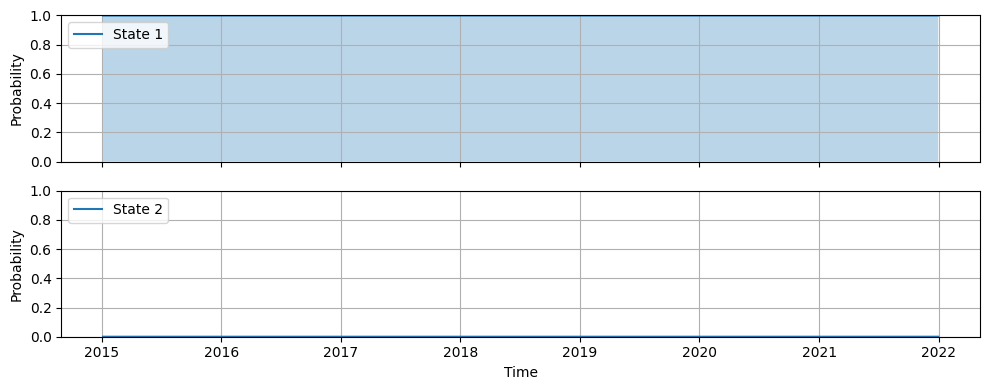

In [85]:
import matplotlib.pyplot as plt
import numpy as np


# Create a plot for each time series of u_hat, plotted below each other
fig, axs = plt.subplots(N, 1, figsize=(10, N * 2), sharex=True)

for i in range(N): 
    axs[i].plot(dates, u_hat[i, :], label=f'State {i+1}', linestyle='-') # Use dates here
    axs[i].set_ylim(0, 1)
    axs[i].fill_between(dates, 0, u_hat[i, :], alpha=0.3)  # Use dates here
    axs[i].legend(loc='upper left')
    axs[i].set_ylabel(f'Probability')
    axs[i].grid(True)

axs[-1].set_xlabel('Time')
plt.tight_layout()
plt.savefig(f'Smoothed TLT.png')
plt.show()



In [74]:
transition_matrix

array([[0.98156993, 0.01843007],
       [0.0295779 , 0.9704221 ]])

In [76]:
correlation_matrix

array([[[ 1.        ,  0.77973156, -0.13274446],
        [ 0.77973156,  1.        , -0.15722027],
        [-0.13274446, -0.15722027,  1.        ]],

       [[ 1.        ,  0.73252857, -0.59260476],
        [ 0.73252857,  1.        , -0.4536792 ],
        [-0.59260476, -0.4536792 ,  1.        ]]])

In [77]:
corr_1 = correlation_matrix[0]
corr_2 = correlation_matrix[1]

std_1 = np.mean(standard_deviations * u_hat[0], axis=1)
std_2 = np.mean(standard_deviations * u_hat[1], axis=1)

diag_1 = np.diag(std_1)
diag_2 = np.diag(std_2)
cov_1 = diag_1 @ corr_1 @ diag_1
cov_2 = diag_2 @ corr_2 @ diag_2
cov = (cov_1 + cov_2) / 2
cov_1, cov_2, cov


(array([[ 0.31594523,  0.33657248, -0.03879176],
        [ 0.33657248,  0.58973267, -0.06277016],
        [-0.03879176, -0.06277016,  0.27029266]]),
 array([[ 0.12389003,  0.1237189 , -0.06212272],
        [ 0.1237189 ,  0.23024309, -0.06483497],
        [-0.06212272, -0.06483497,  0.08870217]]),
 array([[ 0.21991763,  0.23014569, -0.05045724],
        [ 0.23014569,  0.40998788, -0.06380257],
        [-0.05045724, -0.06380257,  0.17949742]]))

In [78]:
import numpy as np
from numpy.linalg import inv
import cvxpy as cp

def optimize_portfolio(cov_matrix, expected_returns, target_return):
    """
    Finds the optimal portfolio weights using Markowitz optimization.
    
    Parameters:
    - cov_matrix: A covariance matrix of asset returns.
    - expected_returns: An array of expected returns for each asset.
    - target_return: The target return for the portfolio.
    
    Returns:
    - A tuple (weights, risk), where 'weights' is an array of optimal asset weights, and 'risk' is the portfolio risk (standard deviation).
    """
    num_assets = len(expected_returns)
    
    # Define the optimization variables
    weights = cp.Variable(num_assets)
    
    # Define the objective function (minimize portfolio variance)
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    objective = cp.Minimize(portfolio_variance)
    
    # Define the constraints
    constraints = [
        cp.sum(weights) == 1,  # Sum of weights must be 1
        weights >= 0,          # No short selling
        cp.matmul(weights, expected_returns) >= target_return  # Target return constraint
    ]
    
    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    # Extract the optimal weights and calculate portfolio risk
    optimal_weights = weights.value
    portfolio_risk = cp.sqrt(portfolio_variance).value
    
    return optimal_weights, portfolio_risk

 # Correct matrix multiplication for covariance
data =  data + means[:,np.newaxis]
mu_1 = np.mean(data * u_hat[0], axis=1)  # Expected returns vector
mu_2 = np.mean(data * u_hat[1], axis=1)  # Expected returns vector
mu = np.mean((data * u_hat[0] + data * u_hat[1]),axis=1)
mu_p = 0.02  # Target return
print(f'Returns Combined :  \n{mu}')
print(f'Returns in state 1:  \n{mu_1}')
print(f'Returns in state 2:  \n{mu_2}')


optimal_weights_1, portfolio_risk_1 = optimize_portfolio(cov_1, mu_1, mu_p)
optimal_weights_2, portfolio_risk_2 = optimize_portfolio(cov_2, mu_2, mu_p)
optimal_weights, portfolio_risk = optimize_portfolio(cov, mu, mu_p)
print(f'Optimal Weigts Combined :  \n{optimal_weights}')
print(f'Optimal Weigts in state 1:  \n{optimal_weights_1}')
print(f'Optimal Weigts in state 2:  \n{optimal_weights_2}')
print(portfolio_risk, portfolio_risk_1, portfolio_risk_2)
retun = optimal_weights * mu
mean_return = np.mean(retun)
sharpe = mean_return / portfolio_risk
sharpe

Returns Combined :  
[0.04800628 0.0301353  0.02129648]
Returns in state 1:  
[ 0.03468304  0.02077805 -0.01297087]
Returns in state 2:  
[0.01332324 0.00935726 0.03426735]
Optimal Weigts Combined :  
[0.44400349 0.01490086 0.54109565]
Optimal Weigts in state 1:  
[6.91881692e-01 6.38064513e-24 3.08118308e-01]
Optimal Weigts in state 2:  
[0.43289712 0.01475887 0.55234401]
0.2716088541034018 0.40045530109889826 0.14541140640384248


0.04085216676770706

In [ ]:
0.03555774455398615 / 0.017743666752914767 -1

In [79]:
sharpe = mean_return / portfolio_risk
sharpe

0.04085216676770706

In [112]:
data.shape

(2, 2263)

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats



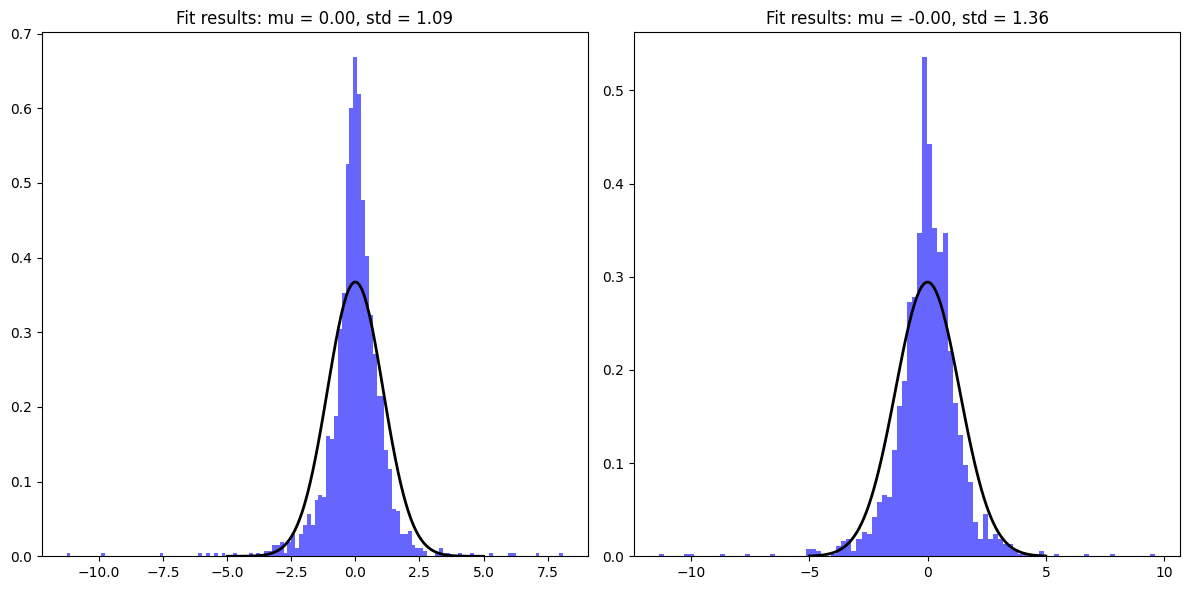

In [82]:
# Example data array for demonstration, assuming it has the same shape as 'standard_deviations'.
# This should be replaced with the actual 'data' array.

# Calculating the residuals as standard_deviations/data
residuals = (data-means[:,np.newaxis]) / standard_deviations
residuals = residuals*standard_deviations
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i in range(2):
    # Histogram for each row of residuals
    axs[i].hist(residuals[i], bins='auto', density=True, alpha=0.6, color='b')
    axs[i].set_title(f"Residuals Histogram {i+1}")
    # Fit and plot the normal distribution
    mu, std = stats.norm.fit(residuals[i])
    xmin, xmax = plt.xlim()
    x = np.linspace(-5, 5, 100)#(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    axs[i].plot(x, p, 'k', linewidth=2)
    title = f"Fit results: mu = {mu:.2f}, std = {std:.2f}"
    axs[i].set_title(title)
plt.tight_layout()
plt.savefig('residuals.png')
plt.show()


# CVXPY Optimization



In [ ]:
# import cvxpy as cp
# import numpy as np

# # Number of assets
# # Portfolio weights
# x = cp.Variable(K)

# # Portfolio return
# portfolio_return = mu.T @ x

# # Portfolio variance
# portfolio_variance = cp.quad_form(x, cov)
# import cvxpy as cp
# import numpy as np

# # Number of assets
# # Portfolio weights
# x = cp.Variable(K)

# # Portfolio return
# portfolio_return = mu.T @ x

# # Portfolio variance
# portfolio_variance = cp.quad_form(x, cov)

# # Objective: Minimize portfolio variance
# objective = cp.Minimize(portfolio_variance)

# # Constraints
# constraints = [cp.sum(x) == 1,  # Sum of weights is 1
#                 x >= 0,         # No short selling
#                 x <= 1,         # No leveraging
#                 portfolio_return >= mu_p]  # Target return

# # Problem
# problem = cp.Problem(objective, constraints)

# # Solve the problem
# problem.solve()

# # Optimized portfolio weights
# x_value = x.value
# x_value
# # Objective: Minimize portfolio variance
# objective = cp.Minimize(portfolio_variance)

# # Constraints
# constraints = [cp.sum(x) == 1,  # Sum of weights is 1
#                 x >= 0,         # No short selling
#                 x <= 1,         # No leveraging
#                 portfolio_return >= mu_p]  # Target return

# # Problem
# problem = cp.Problem(objective, constraints)

# # Solve the problem
# problem.solve()

# # Optimized portfolio weights
# x_value = x.value
# x_value

## Sharpe Ratio
***


## Maximization Functions
**Calculate Log Likelihood**

**Estimate Model Parameters**

## Uniting Functions

## Running


In [ ]:
# start_time = time.time()

# correlation_matrix, transition_matrix, log_hist, u_hat = fit(data, univariate_parameters, num_states=2)
# # End timing
# end_time = time.time()

# # Calculate elapsed time
# elapsed_time = end_time - start_time

# # Print elapsed time with 5 digits after the decimal point
# print(f"Elapsed time: {elapsed_time:.5f} seconds")


In [ ]:
transition_matrix


# Convergence Testing



In [ ]:
# import matplotlib.pyplot as plt
# univariate_parameters = np.array([[0.05, 0.15, 0.75],
#                       [0.1, 0.25, 0.6] ])#,
#                       # [0.15, 0.15, 0.8],
#                       # [0.2, 0.3, 0.65]])
# true_correlation_matrix = np.array([[[1, 0.7],[0.7,1]],[[1, -0.6],[-0.6, 1]]])
# diagonal = 0.99
# N = 2
# K = 2
# true_transition_matrix = diagonal * np.eye(N) + (1-diagonal) * (np.ones((N,N)) - np.eye(N,N)) / (N - 1)

# cholesky = cholesky_form(true_correlation_matrix, N, K)

# # Number of observations
# T = 10000
# iterations = 10000
# plot_every = 10

# max_rho = []
# min_rho = []
# trans_diff = []

# for iteration in range(iterations):
#     # Simulate data
#     data, states, variances, innovations = simulate_data(K, T, univariate_parameters, true_transition_matrix, cholesky)
    
#     # Fit model
#     correlation_matrix, transition_matrix, log_hist = fit(data, univariate_parameters, num_states=2)

#     values = np.zeros(2)
#     # Analyze correlation matrices
#     for i in range(N):
#         values[i] = correlation_matrix[i][np.triu_indices(K, 1)]



#     max = np.max(values)
#     min = np.min(values)
#     max_rho.append(max - 0.7)
#     min_rho.append(min + 0.6)
#     # Analyze transition matrices
#     trans_diff.extend(np.diag(transition_matrix) - 0.99)
    
#     # Plot if condition is met
#     if (iteration + 1) % plot_every == 0:
#         plt.figure(figsize=(10, 4))
#         plt.subplot(1, 3, 1)
#         plt.hist(max_rho, color='skyblue', label='Max Rho')
#         plt.title('Max Rho')
#         plt.subplot(1, 3, 2)
#         plt.hist(min_rho, color='salmon', label='Min Rho')
#         plt.title('Min Rho')
#         plt.subplot(1, 3, 3)
#         plt.hist(trans_diff, color='lightgreen', label='Transition Diff')
#         plt.title('Transition Diff')
#         plt.tight_layout()
#         plt.savefig(f'RSDC test iteration {iteration}.png')
#         plt.close()
# # data, states, variances, innovations = simulate_data(K,T, univariate_parameters, true_transition_matrix, cholesky)

# # correlation_matrix, transition_matrix, log_hist, u_hat = fit(data, univariate_parameters, num_states=2)

In [ ]:
# densities.shape,np.max(densities), np.min(densities), densities

In [ ]:
# np.sum(estimated_transition, axis=1)

In [ ]:
# alpha, beta

In [ ]:
# initial_states, u_hat, v_hat

In [ ]:
# estimated_transition

In [ ]:

# start_time = time.time()


# standard_deviations = calculate_standard_deviations(data, parameters)
# residuals = calculate_residuals(data, standard_deviations)
# true_states = form_states(states, N, T)
# correlation_matrix = estimate_model_parameters(res, true_states)
# scaled = np.zeros((N, K, K))
# for n in range(N):
#     scaled[n,:,:] = cholesky_scale(correlation_matrix[n,:,:])


# print(scaled)
# # End timing
# end_time = time.time()

# # Calculate elapsed time
# elapsed_time = end_time - start_time

# # Print elapsed time with 5 digits after the decimal point
# print(f"Elapsed time: {elapsed_time:.5f} seconds")


In [ ]:
correlation_matrix

In [ ]:
scaled

In [ ]:
true_correlation_matrix